Google translated task:
Laboratory work on the module " building models”
1. Upload data from the Data Folder folder
2. To conduct a descriptive analysis of the proposed data
3. Suggest a strategy for working with categorical variables
4. Conduct an in-depth analysis of data (correlations of variables, visualization of relationships)
5. Should I increase/decrease the dimension of the feature set (which approach gives the best results)
6. Should classes be balanced by oversampling/undersampling? (does the approach improve results)
7. Perform cross-validation of data using the K-fold approach (n_folds=3)
8. Solve the problem of multiCLASS classification and predict the country's religion by the details of its flag
9. To compute Feature Importances for variables of the model
10. Check the quality of classification using the following metrics: Accuracy, F1-Score, Precision, Recall
11. Build a Confusion Matrix for your results
12. Upload ipython notebook with the results to the github repository
* Items that you find difficult or that you don't know can be skipped, but with a note in your laptop that
it seemed difficult and incomprehensible at this point for you.

In [45]:
import pandas as pd
from pandas_profiling import ProfileReport

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import mplcyberpunk
from pylab import rcParams

In [2]:
data = pd.read_csv('flag.data', header=None)
data.columns = ['name',
 'landmass',
 'zone',
 'area',
 'population',
 'language',
 'religion',
 'bars',
 'stripes',
 'colours',
 'red',
 'green',
 'blue',
 'gold',
 'white',
 'black',
 'orange',
 'mainhue',
 'circles',
 'crosses',
 'saltires',
 'quarters',
 'sunstars',
 'crescent',
 'triangle',
 'icon',
 'animate',
 'text',
 'topleft',
 'botright']

Attribute Information:

1. name: Name of the country concerned
2. landmass: 1=N.America, 2=S.America, 3=Europe, 4=Africa, 4=Asia, 6=Oceania
3. zone: Geographic quadrant, based on Greenwich and the Equator; 1=NE, 2=SE, 3=SW, 4=NW
4. area: in thousands of square km
5. population: in round millions
6. language: 1=English, 2=Spanish, 3=French, 4=German, 5=Slavic, 6=Other Indo-European, 7=Chinese, 8=Arabic, 9=Japanese/Turkish/Finnish/Magyar, 10=Others
7. religion: 0=Catholic, 1=Other Christian, 2=Muslim, 3=Buddhist, 4=Hindu, 5=Ethnic, 6=Marxist, 7=Others
8. bars: Number of vertical bars in the flag
9. stripes: Number of horizontal stripes in the flag
10. colours: Number of different colours in the flag
11. red: 0 if red absent, 1 if red present in the flag
12. green: same for green
13. blue: same for blue
14. gold: same for gold (also yellow)
15. white: same for white
16. black: same for black
17. orange: same for orange (also brown)
18. mainhue: predominant colour in the flag (tie-breaks decided by taking the topmost hue, if that fails then the most central hue, and if that fails the leftmost hue)
19. circles: Number of circles in the flag
20. crosses: Number of (upright) crosses
21. saltires: Number of diagonal crosses
22. quarters: Number of quartered sections
23. sunstars: Number of sun or star symbols
24. crescent: 1 if a crescent moon symbol present, else 0
25. triangle: 1 if any triangles present, 0 otherwise
26. icon: 1 if an inanimate image present (e.g., a boat), otherwise 0
27. animate: 1 if an animate image (e.g., an eagle, a tree, a human hand) present, 0 otherwise
28. text: 1 if any letters or writing on the flag (e.g., a motto or slogan), 0 otherwise
29. topleft: colour in the top-left corner (moving right to decide tie-breaks)
30. botright: Colour in the bottom-left corner (moving left to decide tie-breaks)

In [3]:
# remove names of countries - each row have unique data and it is useless for prediction
del(data['name'])

In [4]:
ProfileReport(data)

* A lot of zero values in the column "population", because a population is represented in round millions, and many countries don't have even 500k population

In [10]:
# Remove one of strong correlation features
# leave crosses
del(data['saltires'])

# leave landmass
del(data['zone'])
del(data['language'])

# leave white
del(data['gold'])

# leave area
del(data['population'])

In [29]:
data['mainhue'].unique()

array(['green', 'red', 'blue', 'gold', 'white', 'orange', 'black',
       'brown'], dtype=object)

**We will use RandomForest as classifier, so we are free to use label encoding** 

In [5]:
data['topleft'] = data['topleft'].astype("category").cat.codes
data['botright'] = data['botright'].astype("category").cat.codes
data['mainhue'] = data['mainhue'].astype("category").cat.codes

In [31]:
ProfileReport(data)

Strong correlation between icon/animate and colours. Because complex pictures have a lot of colours :) Let's remove colours feature, it has strong correlation with icon/animate, and additionally, we have a standalone feature for every colour.

In [33]:
del(data['colours'])

# strong correlation with botright
del(data['mainhue'])

In [19]:
# find out how many rows have each religion

data.groupby('religion').agg(['count'])

,landmass,area,bars,stripes,red,green,blue,white,black,orange,...,crosses,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
,count,count,count,count,count,count,count,count,count,count,...,count,count,count,count,count,count,count,count,count,count
religion,,,,,,,,,,,,,,,,,,,,,
0,40,40,40,40,40,40,40,40,40,40,...,40,40,40,40,40,40,40,40,40,40
1,60,60,60,60,60,60,60,60,60,60,...,60,60,60,60,60,60,60,60,60,60
2,36,36,36,36,36,36,36,36,36,36,...,36,36,36,36,36,36,36,36,36,36
3,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
4,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
5,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27
6,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
7,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4


As we can see, there are at least 3 outsiders, which have less data than other religions. I chose a RandomForestClassifier as an estimator for this dataset. This is why I should do something to balance the dataset. But first I will do fit without oversampling. So I can see if my techniques improve results.

In [6]:
X = data.copy()
del(X['religion'])
y = data['religion']

In [7]:
model = RandomForestClassifier(n_estimators=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [10]:
p = model.predict(X_test)

In [11]:
print('Accuracy score: ', accuracy_score(y_test, p))
print('F1 score: ', f1_score(y_test, p, average='micro'))
print('Precision: ', precision_score(y_test, p, average='micro'))
print('Recall: ', recall_score(y_test, p, average='micro'))

Accuracy score:  0.6153846153846154
F1 score:  0.6153846153846154
Precision:  0.6153846153846154
Recall:  0.6153846153846154


**Awful result!** Was 0.53 when i did this with removing "strong correlation". The result is better when we don't remove anything from X, except country name. Maybe oversampling will help to increase the model quality.

## Random oversampling

In [12]:
sample = RandomOverSampler()
X_s, y_s = sample.fit_resample(X,y)

In [16]:
y_s.value_counts()

7    60
6    60
5    60
4    60
3    60
2    60
1    60
0    60
Name: religion, dtype: int64

In [18]:
# Oversampling complete. Test model
X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)
p = model.predict(X_test)

In [19]:
print('Accuracy score: ', accuracy_score(y_test, p))
print('F1 score: ', f1_score(y_test, p, average='micro'))
print('Precision: ', precision_score(y_test, p, average='micro'))
print('Recall: ', recall_score(y_test, p, average='micro'))

Accuracy score:  0.9375
F1 score:  0.9375
Precision:  0.9375
Recall:  0.9375


Wow! Amazing result. Cross validate this.

In [25]:
kf = KFold(n_splits=3)
i = 0

for train, test in kf.split(X_s):
    i+=1
    X_train, X_test = X_s.values[train], X_s.values[test]
    y_train, y_test = y_s.values[train], y_s.values[test]
    
    model.fit(X_train, y_train)
    p = model.predict(X_test)
    
    print('Fold #', i)
    print('Accuracy score: ', accuracy_score(y_test, p))
    print('F1 score: ', f1_score(y_test, p, average='micro'))
    print('Precision: ', precision_score(y_test, p, average='micro'))
    print('Recall: ', recall_score(y_test, p, average='micro'))

Fold # 1
Accuracy score:  0.825
F1 score:  0.825
Precision:  0.825
Recall:  0.825
Fold # 2
Accuracy score:  0.83125
F1 score:  0.83125
Precision:  0.83125
Recall:  0.83125
Fold # 3
Accuracy score:  1.0
F1 score:  1.0
Precision:  1.0
Recall:  1.0


Still good results.

# Feature Importance

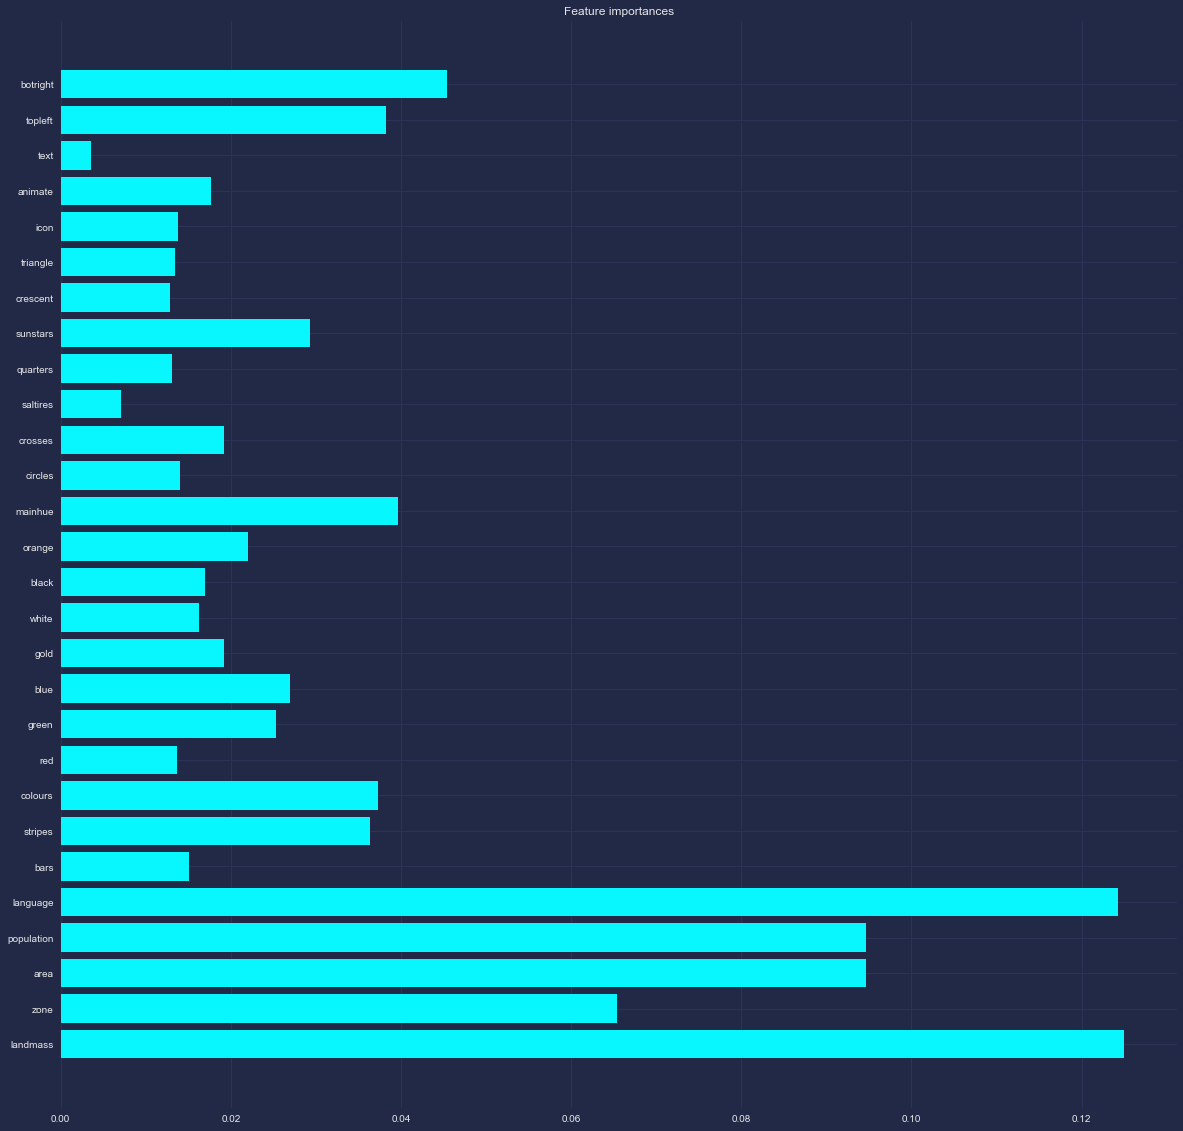

In [37]:
importance = model.feature_importances_
rcParams['figure.figsize'] = 20, 20
plt.style.use("cyberpunk")
plt.figure()
plt.title("Feature importances")
plt.barh(X_s.columns, importance)

plt.show()

As we can see the idea to predict religion by a flag is not good. Most important is geography, population, and language, which are not part of the flag actually. The most important feature of flags itself is botright.

# Confusion Matrix

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)
p = model.predict(X_test)

cm = confusion_matrix(y_test, p)

In [52]:
cm

array([[ 8,  0,  0,  0,  0,  0,  2,  0],
       [ 0, 13,  0,  0,  0,  2,  0,  0],
       [ 0,  0, 12,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  8,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 15,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  8,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 12,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 15]], dtype=int64)

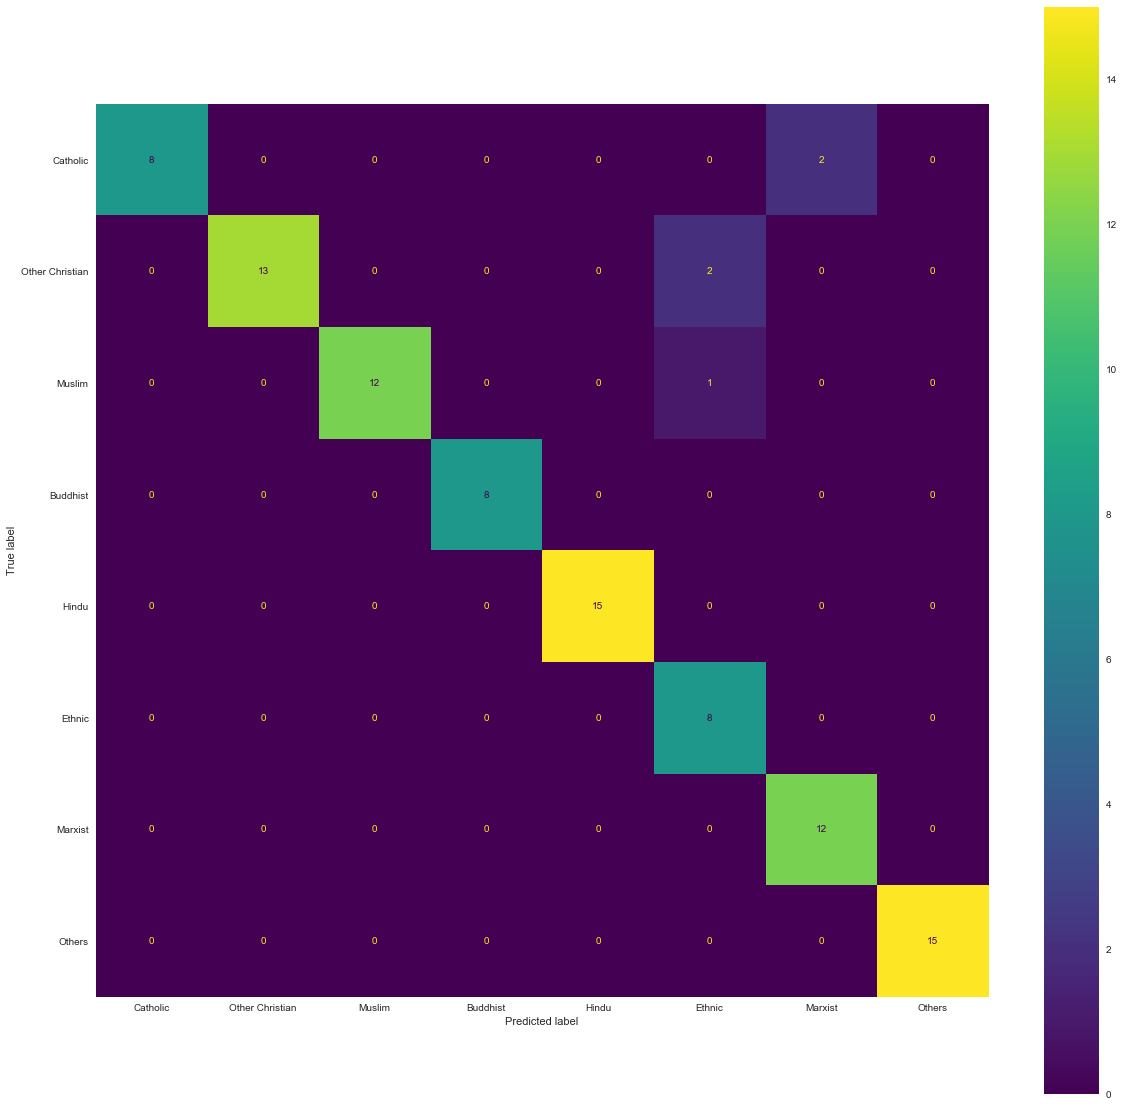

In [53]:
plt.style.use("seaborn-dark")
ConfusionMatrixDisplay(cm, ['Catholic', 'Other Christian', 'Muslim', 'Buddhist', 'Hindu', 'Ethnic', 'Marxist', 'Others']).plot()